**1.IMPORTING LIBRARIES**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import cv2
import pandas as pd
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img ,array_to_img ,img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

2024-04-29 13:46:43.402669: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-29 13:46:43.402760: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-29 13:46:43.564311: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


**2.LOAD THE IMAGE TRAINING ANG VALIDATION DATASET**

In [2]:
original_images_dir='/kaggle/input/air-pollution-image-dataset-from-india-and-nepal/Air Pollution Image Dataset/Air Pollution Image Dataset/Combined_Dataset/IND_and_NEP'
validation_df = pd.read_csv('/kaggle/input/air-pollution-image-dataset-from-india-and-nepal/Dataset_for_AQI_Classification/Dataset_for_AQI_Classification/val_data.csv')


a.Creating a directory for augmented images

In [3]:

save_dir = '/kaggle/working/augmented_images'
os.makedirs(save_dir, exist_ok=True)


In [4]:
IMG_WIDTH = 224
IMG_HEIGHT = 224
BATCH_SIZE = 64

In [5]:
train_dataset_path = '/kaggle/working/augmented_images'

image_dir='/kaggle/input/air-pollution-image-dataset-from-india-and-nepal/Air Pollution Image Dataset/Air Pollution Image Dataset/Combined_Dataset/IND_and_NEP'
directories = [d for d in os.listdir(image_dir) if os.path.isdir(os.path.join(image_dir, d))]
for i in directories:
    if not os.path.exists(train_dataset_path+'/'+i):
        os.makedirs(train_dataset_path+'/'+i)

b.Image Augmentation

In [6]:
datagen = ImageDataGenerator(
        rotation_range=40,          # Rotate images by up to 40 degrees
        width_shift_range=0.2,      # Shift width by up to 20% of image width
        height_shift_range=0.2,     # Shift height by up to 20% of image height
        shear_range=0.2,            # Apply shear transformation with intensity up to 20%
        zoom_range=0.2,             # Zoom in or out by up to 20%
        horizontal_flip=True,      # Flip images horizontally
        vertical_flip=True,
        brightness_range=[0.5, 1.5],  # Adjust brightness
        channel_shift_range=10 ,        # Shift color channels
        fill_mode='nearest')        # Fill mode for points outside the input boundaries


image_dir='/kaggle/input/air-pollution-image-dataset-from-india-and-nepal/Air Pollution Image Dataset/Air Pollution Image Dataset/Combined_Dataset/IND_and_NEP'
directories = [d for d in os.listdir(image_dir) if os.path.isdir(os.path.join(image_dir, d))]
for dirr in directories:
    image_files = [os.path.join(image_dir+'/'+dirr+'/', f) for f in os.listdir(image_dir+'/'+dirr+'/') if f.endswith('.jpg')]
    
    for image in image_files: 
        img = load_img(image) 
        x = img_to_array(img)  
        x = x.reshape((1,) + x.shape)
        i = 0
        for batch in datagen.flow(x, batch_size=1,
            save_to_dir=(train_dataset_path+'/'+dirr), save_prefix=[j for j in image[::-1].split('/')][0], save_format='jpg'):
            i += 1
            if i > 20:
                break 
                     


In [7]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                  zoom_range=0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(train_dataset_path,
                                                   target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                   batch_size=BATCH_SIZE,
                                                   class_mode='categorical',
                                                   shuffle=True)

Found 256776 images belonging to 6 classes.


In [8]:
validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=validation_df,
    directory='/kaggle/input/air-pollution-image-dataset-from-india-and-nepal/Air Pollution Image Dataset/Air Pollution Image Dataset/Combined_Dataset/All_img',
    x_col='Filename',
    y_col='AQI_Class',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)


Found 1959 validated image filenames belonging to 6 classes.


c.Get the label mapping

In [9]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : a_Good
1 : b_Moderate
2 : c_Unhealthy_for_Sensitive_Groups
3 : d_Unhealthy
4 : e_Very_Unhealthy
5 : f_Severe


**3.PLOTTING SAMPLE TRAINING IMAGES**

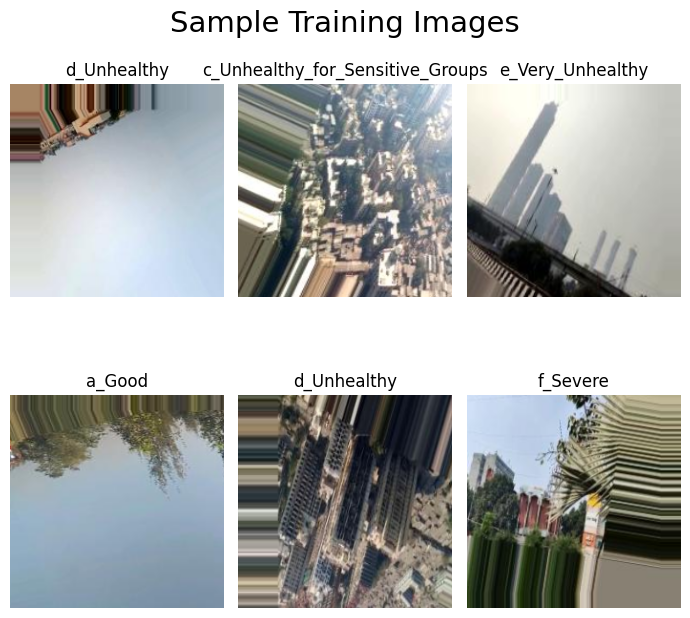

In [10]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(7, 7))
idx = 0

for i in range(2):
    for j in range(3):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()

**4.TRAINING A CNN MODEL**

a.Create a CNN Model

In [11]:
def create_model():
    model = Sequential([
        Conv2D(filters=128, kernel_size=(5, 5), padding='valid', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(filters=64, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(filters=32, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Flatten(),
        
        Dense(units=256, activation='relu'),
        Dropout(0.5),
        Dense(units=6, activation='softmax')
    ])
    
    return model

In [12]:
cnn_model = create_model()

In [13]:
print(cnn_model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 220, 220, 128)  │         9,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 220, 220, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 110, 110, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 110, 110, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 108, 108, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 108, 108, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 54, 54, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 52, 52, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 21632)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     5,538,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,642,470 (21.52 MB)

 Trainable params: 5,642,022 (21.52 MB)

 Non-trainable params: 448 (1.75 KB)

None


In [14]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)

In [15]:
optimizer = Adam(learning_rate=0.001)

In [16]:
cnn_model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])

In [17]:
history = cnn_model.fit(train_generator, epochs=10, validation_data=validation_generator,
                       verbose=2,
                       callbacks=[reduce_lr])

Epoch 1/10


I0000 00:00:1714401697.800931     122 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1714401697.822182     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1714402177.948279     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1714404475.287110     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


4013/4013 - 2840s - 708ms/step - accuracy: 0.4734 - loss: 1.6241 - val_accuracy: 0.4359 - val_loss: 2.8172 - learning_rate: 0.0010
Epoch 2/10


W0000 00:00:1714404500.343630     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


4013/4013 - 3016s - 752ms/step - accuracy: 0.5836 - loss: 1.0297 - val_accuracy: 0.6907 - val_loss: 0.7645 - learning_rate: 0.0010
Epoch 3/10
4013/4013 - 2792s - 696ms/step - accuracy: 0.6334 - loss: 0.9108 - val_accuracy: 0.6963 - val_loss: 0.7440 - learning_rate: 0.0010
Epoch 4/10
4013/4013 - 2787s - 695ms/step - accuracy: 0.6713 - loss: 0.8254 - val_accuracy: 0.7422 - val_loss: 0.7074 - learning_rate: 0.0010
Epoch 5/10
4013/4013 - 2832s - 706ms/step - accuracy: 0.6999 - loss: 0.7602 - val_accuracy: 0.7233 - val_loss: 0.9314 - learning_rate: 0.0010
Epoch 6/10
4013/4013 - 2822s - 703ms/step - accuracy: 0.7212 - loss: 0.7167 - val_accuracy: 0.7703 - val_loss: 0.6458 - learning_rate: 0.0010
Epoch 7/10
4013/4013 - 2799s - 698ms/step - accuracy: 0.7369 - loss: 0.6815 - val_accuracy: 0.8132 - val_loss: 0.4749 - learning_rate: 0.0010
Epoch 8/10
4013/4013 - 2780s - 693ms/step - accuracy: 0.7486 - loss: 0.6569 - val_accuracy: 0.7693 - val_loss: 0.7975 - learning_rate: 0.0010
Epoch 9/10
4013/4

**5.PLOTTING THE MODEL METRICS**

In [18]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

learning_rate = history.history['learning_rate']

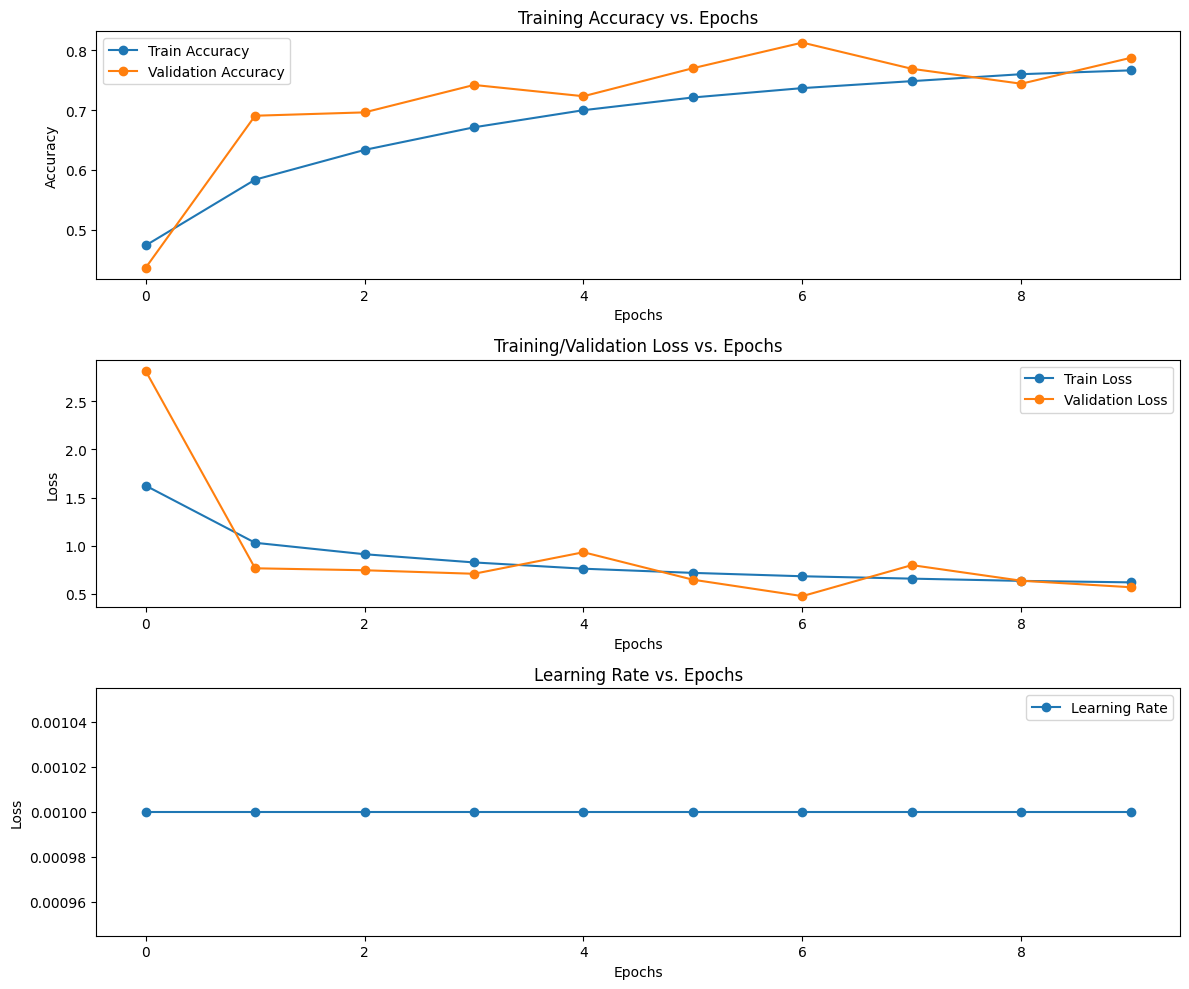

In [19]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')
ax[2].set_title('Learning Rate vs. Epochs')
ax[2].plot(learning_rate, 'o-', label='Learning Rate')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Loss')
ax[2].legend(loc='best')

plt.tight_layout()
plt.show()


**6.TESTING THE MODEL ON TESTSET**

In [20]:
test_df= pd.read_csv('/kaggle/input/air-pollution-image-dataset-from-india-and-nepal/Dataset_for_AQI_Classification/Dataset_for_AQI_Classification/testing_data.csv')

In [21]:

test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_dataframe( 
                                                 dataframe=test_df,
                                                 directory='/kaggle/input/air-pollution-image-dataset-from-india-and-nepal/Air Pollution Image Dataset/Air Pollution Image Dataset/Combined_Dataset/All_img',
                                                 x_col='Filename',
                                                 y_col='AQI_Class',
                                                 shuffle=False,
                                                 batch_size=BATCH_SIZE,
                                                 target_size = (IMG_WIDTH, IMG_HEIGHT),
                                                 class_mode='categorical')

Found 2448 validated image filenames belonging to 6 classes.


**7.MODEL PREDICTION ON TEST**

In [22]:
predictions = cnn_model.predict(test_generator)

 2/39 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step  

W0000 00:00:1714430002.616050     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


39/39 ━━━━━━━━━━━━━━━━━━━━ 22s 552ms/step


W0000 00:00:1714430023.582429     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


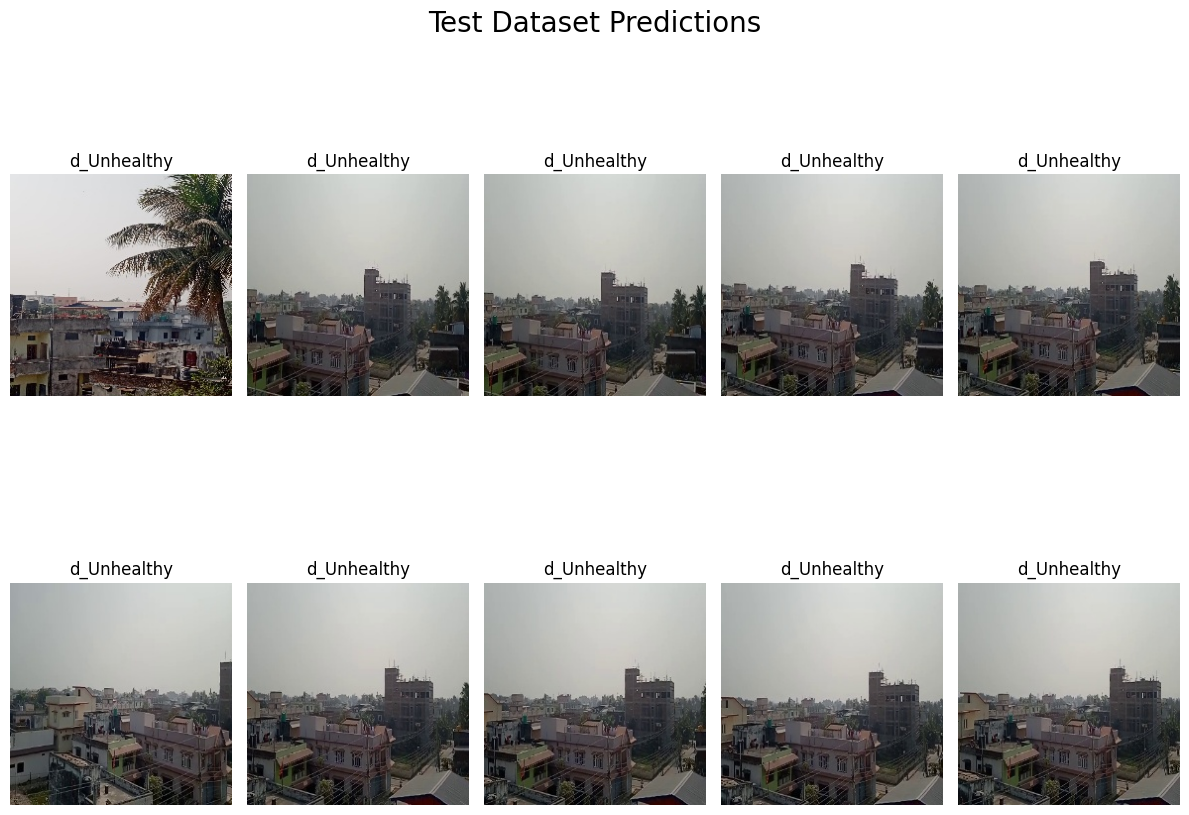

In [23]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        predicted_label = labels[np.argmax(predictions[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(test_generator[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()

In [24]:
test_loss, test_accuracy = cnn_model.evaluate(test_generator, batch_size=BATCH_SIZE)

39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 169ms/step - accuracy: 0.8025 - loss: 0.5513


W0000 00:00:1714430033.206776     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [25]:
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss:     0.5957338213920593
Test Accuracy: 0.7761437892913818


**8.PLOTTING THE CLASSIFICATION METRICS**

a.Confusion Matrix

In [26]:
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

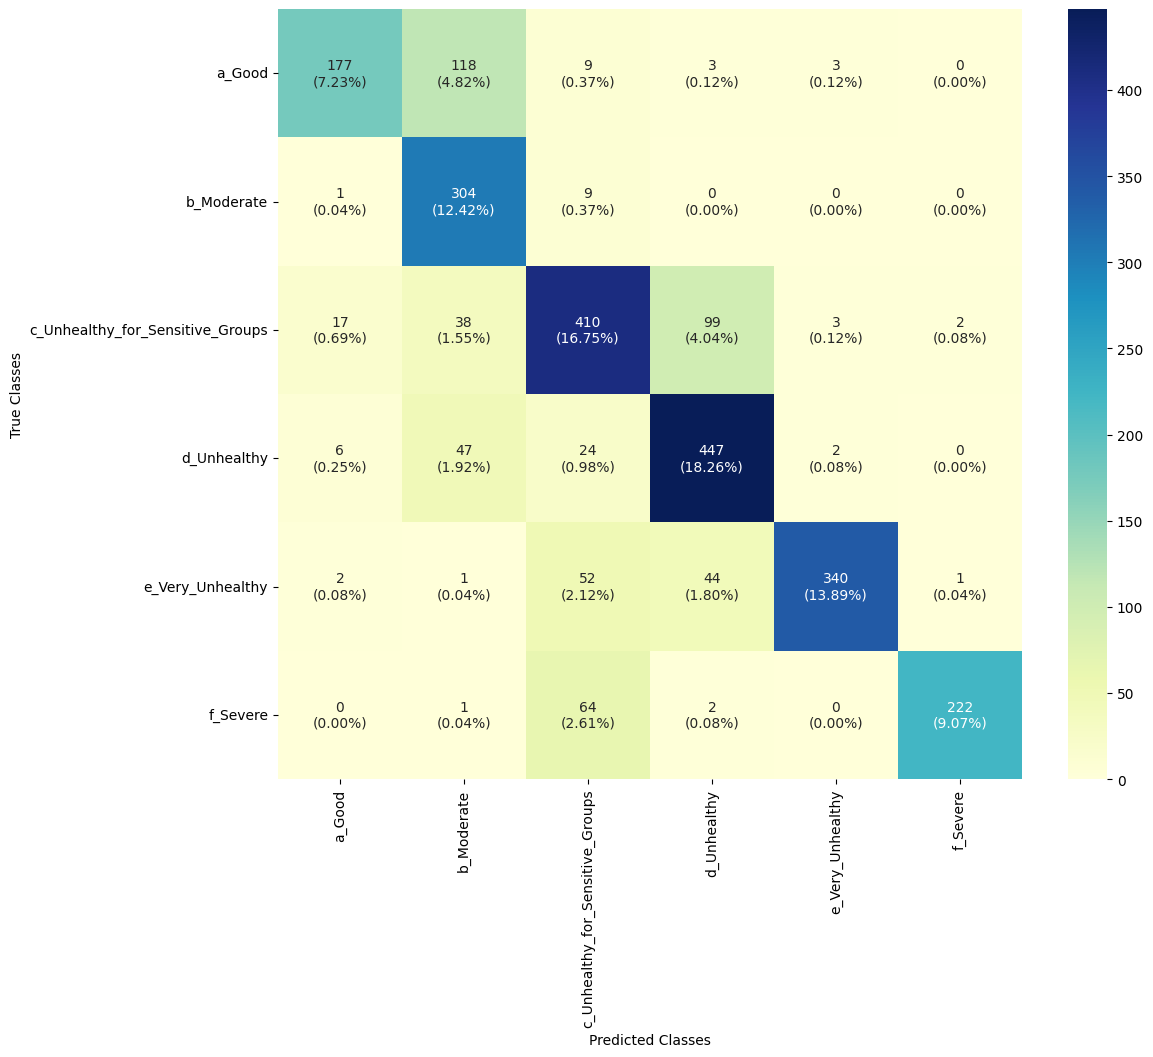

In [27]:
cf_mtx = confusion_matrix(y_true, y_pred)

group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten()/np.sum(cf_mtx)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(6, 6)

plt.figure(figsize = (12, 10))
sns.heatmap(cf_mtx, xticklabels=labels.values(), yticklabels=labels.values(),
           cmap="YlGnBu", fmt="", annot=box_labels)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

In [28]:
print(classification_report(y_true, y_pred, target_names=labels.values()))

                                  precision    recall  f1-score   support

                          a_Good       0.87      0.57      0.69       310
                      b_Moderate       0.60      0.97      0.74       314
c_Unhealthy_for_Sensitive_Groups       0.72      0.72      0.72       569
                     d_Unhealthy       0.75      0.85      0.80       526
                e_Very_Unhealthy       0.98      0.77      0.86       440
                        f_Severe       0.99      0.77      0.86       289

                        accuracy                           0.78      2448
                       macro avg       0.82      0.78      0.78      2448
                    weighted avg       0.81      0.78      0.78      2448



In [30]:
cnn_model.save('/kaggle/working/class.h5')